In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
# from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array, collatev2
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer, ISAVIT
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder
import seaborn as sns


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
C:\Users\araza\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

cases = ds.load_raw_mri()
masks = ds.load_cmb_masks()

In [4]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 3)

In [5]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(385, 3)

In [6]:
cases = data.mri
masks = data.masks
target = data.target

# Vit Dataloader

In [7]:
transform = NiftiToTensorTransform(target_shape = (512, 512), rpn_mode=False)

In [8]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=transform,
    normalization=z_score_normalization,
)

In [9]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collatev2,
)

# Feeder Dataset

In [10]:
feedset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=NiftiToTensorTransform(target_shape = (512, 512), rpn_mode=True),
    normalization=z_score_normalization,
)

# Feeder

In [11]:
resize = get_transform(
    height=16,
    width=16,
    p=1.0,
    rpn_mode=False
)

In [12]:
feeder = Feeder(resize)

In [13]:
torch.zeros(16, 16).shape

torch.Size([16, 16])

# Fitter Config

In [14]:
config = {
    'model': ISAVIT(
        d_model=1000,
        patch_size=16,
        dim_ff=2000
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 1,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0000001
}

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Sample

# Fitter

In [15]:
from project import Fitter

class ViTFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                num_slices = slices.shape[0]
                
                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                print(f'BBOXES: {bboxes.shape}')
                bbox = bboxes[target].int().tolist()

                print(f'X shape before feeder {slices.shape}')
                print(f'T shape before feeder {masks.shape}')
                x = feeder(slices, bbox, 16)
                t = feeder(masks, bbox, 16)
                print(f'X shape after feeder {x.shape}')
                print(f'T shape after feeder {t.shape}')
                x = x.view(num_slices, 1, -1).float().to(self.device)
                masks = t.view(num_slices, 1, -1).float().to(self.device)
                print(f'X SHAPE {x.shape}')
                print(f'T SHAPE {masks.shape}')
                
                y = self.model(x, target)
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            # losses = self.loss(torch.stack(T), torch.stack(Y))
            loss_history.append(losses)
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(dataset)}')
                logger.info(f'Current error:\t{losses}')
        
        return loss_history

In [16]:
fitter = ViTFitter(config)

# Training

In [17]:
hist = fitter.fit(dloader, dloader)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:andy:Progress:	100/385
INFO:andy:Current error:	0.7421993017196655
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:andy:Progress:	200/385
INFO:andy:Current error:	0.7383832931518555
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:andy:Progress:	300/385
INFO:andy:Current error:	0.7376967668533325
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


BBOXES: torch.Size([35, 4])
X shape before feeder torch.Size([35, 1, 1, 512, 512])
T shape before feeder torch.Size([35, 1, 512, 512])
X shape after feeder torch.Size([35, 1, 16, 16])
T shape after feeder torch.Size([35, 1, 16, 16])
X SHAPE torch.Size([35, 1, 256])
T SHAPE torch.Size([35, 1, 256])


In [18]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

tensor(0.7315)

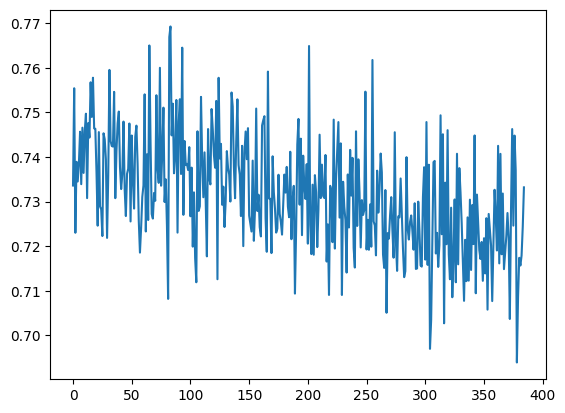

In [19]:
import seaborn as sns

sns.lineplot(torch.tensor(hist).view(-1))
torch.tensor(hist).mean()